In [1]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import seaborn as sns
from utils.mlflow_query import MlflowHelper
import numpy as np
from pathlib import Path
from src.features import knowledge
import json
from matplotlib import pyplot as plt

Detecting 2 CUDA device(s).


In [2]:
mlflow_helper = MlflowHelper(pkl_file=None, 
    local_mlflow_dir_prefix='/home/i40/almasrirz/Domain-Guided-Monitoring/mlruns/', 
    experiment_id="188500769110107699",
    tracking_uri="http://localhost:5200")
mlflow_helper.query_runs()

Querying data per run...: 100%|██████████| 503/503 [00:06<00:00, 77.80it/s]


# Convinience Functions

In [3]:
def plot_best_metric_bar(metric_df, metric_names,
    x_feature_name='data_tags_model_type', 
    x_order=['simple', 'causal_heuristic', 'causal_score'],
    save_fig = False,
    row_feature_name=None,
    hue_feature_name=None,
    col_feature_name=None,
    titles=None,
    palette=None,
    dodge=True,
    col_order=None,
    height=5,
    aspect=1 # width = height * aspect
):
    for metric_name in metric_names:
        g = sns.catplot(
            data=metric_df, x=x_feature_name, y=metric_name, order=x_order,
            row=row_feature_name, hue=hue_feature_name, col=col_feature_name, col_order=col_order,
            kind="box", sharey='row', palette=palette, dodge=dodge, height=height, aspect=aspect
        )
        g.set_titles(titles).set_axis_labels('', metric_name)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True)
        if save_fig:
            g.savefig("bar_{}.png".format(metric_name))

In [4]:
def count_attributes(df: pd.DataFrame, attr='data_tags_model_type'):
    return df.groupby([attr])[attr].count().sort_values(ascending=False)

In [5]:
def read_knowledge_dataframes(knowledge_type, dataset='huawei', size='2k'):
    knowledge_path = Path(f'/home/i40/almasrirz/Domain-Guided-Monitoring/data/final/{size}/{dataset}/knowledge')
    pathlist = knowledge_path.glob('**/*.csv')
    dataframes = {}
    for path in pathlist:
        knowledge_name = path.name.split('_knowledge')[0]
        dataframes[knowledge_name] = pd.read_csv(path)
    return dataframes

In [6]:
def fetch_statistics(knowledge_type, drain_settings, ts=None, dataset='huawei', size='2k'):
    statistics_records = []
    dataframes = read_knowledge_dataframes(knowledge_type, dataset=dataset, size=size)
    for name, df in dataframes.items():
        k = None
        metadata = f'/home/i40/almasrirz/Domain-Guided-Monitoring/data/final/{size}/{dataset}/x_vocab'
        for x in drain_settings:
            if x in name:
                metadata += f'_{x}'
                break
        if 'with_ts' in name:
            metadata += '_with_ts'
        if 'without_ts' in name:
            metadata += '_without_ts'
           
        with open(metadata + '.json', 'r') as file:
            metadata = json.load(file)

        if name.startswith('causal'):
            k = knowledge.CausalityKnowledge(knowledge.KnowledgeConfig())
            k.build_causality_from_df(df, metadata)
        elif name.startswith('hierarchy'):
            k = knowledge.HierarchyKnowledge(knowledge.KnowledgeConfig())
            k.build_hierarchy_from_df(df, metadata)
        else:
            k = knowledge.DescriptionKnowledge(knowledge.KnowledgeConfig())
            k.build_knowledge_from_df(df, metadata)
        v_in = len(k.vocab)
        v_g = len(k.extended_vocab)
        v_hidden = v_g - v_in
        edges = set()
        for i in range(len(k.vocab)):
            connections = k.get_connections_for_idx(i)
            for connection in connections:
                edges.add((i, connection))
        statistics_records.append({
            'Model': name,
            'V_G': v_g,
            'V_in': v_in,
            'V_hidden': v_hidden,
            'E_G': len(edges)
        })

    return pd.DataFrame.from_records(statistics_records)

In [7]:
name2config = { # Name -> (depth, st)
    'Most fine': ('11', '0.8'),
    'Fine': ('10', '0.75'), # default
    'Medium': ('8', '0.7'),
    'Coarse': ('6', '0.6'),
    'Most coarse': ('4', '0.4')
}
config2name = {v: k for k, v in name2config.items()}
depth_values = sorted([x[0] for x in name2config.values()])
st_values = sorted([x[1] for x in name2config.values()])
config_order = ['Most coarse', 'Coarse', 'Medium', 'Fine', 'Most fine']

In [8]:
def classify_sp_df(df, drain_configs, dataset='Huawei'):
    st_column = f"data_params_{dataset}PreprocessorConfigfine_drain_log_st"
    depth_column = f"data_params_{dataset}PreprocessorConfigfine_drain_log_depth"
    ret_df = df.copy()
    for depth, st in drain_configs.values():
        ret_df.loc[(ret_df[depth_column] == depth) & (ret_df[st_column] == st), 'data_tags_model_type'] = (
            ret_df.loc[(ret_df[depth_column] == depth) & (ret_df[st_column] == st), 'data_tags_model_type']
            .apply(lambda x: x + f'_{depth}_{st}'))
    return ret_df

# Drain Settings (Number of Templates) Effect

## 2k

### Huawei

In [9]:
huawei_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'huawei_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/final/2k/huawei/Huawei_2k.csv')
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("").isin(depth_values))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(st_values))
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_df = classify_sp_df(huawei_df, name2config, dataset='Huawei')
huawei_with_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False']
huawei_without_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True']

Querying metrics for runs: 100%|██████████| 120/120 [00:08<00:00, 13.85it/s]


In [10]:
count_attributes(huawei_with_ts_df)

data_tags_model_type
causal_Fast-IAMB-jt_4_0.4      10
simple_4_0.4                   10
causal_Fast-IAMB-jt_10_0.75     5
causal_Fast-IAMB-jt_11_0.8      5
causal_Fast-IAMB-jt_6_0.6       5
causal_Fast-IAMB-jt_8_0.7       5
simple_10_0.75                  5
simple_11_0.8                   5
simple_6_0.6                    5
simple_8_0.7                    5
Name: data_tags_model_type, dtype: int64

In [11]:
count_attributes(huawei_without_ts_df)

data_tags_model_type
causal_Fast-IAMB-jt_4_0.4      10
simple_4_0.4                   10
causal_Fast-IAMB-jt_10_0.75     5
causal_Fast-IAMB-jt_11_0.8      5
causal_Fast-IAMB-jt_6_0.6       5
causal_Fast-IAMB-jt_8_0.7       5
simple_10_0.75                  5
simple_11_0.8                   5
simple_6_0.6                    5
simple_8_0.7                    5
Name: data_tags_model_type, dtype: int64

#### With timestamps

In [12]:
huawei_plot_ts_df = huawei_with_ts_df.copy()
huawei_plot_ts_df['algorithm_type'] = huawei_plot_ts_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
huawei_plot_ts_df['Granularity'] = (
    huawei_plot_ts_df
    .apply(lambda x: config2name[(x['data_params_HuaweiPreprocessorConfigfine_drain_log_depth'], x['data_params_HuaweiPreprocessorConfigfine_drain_log_st'])],
           axis=1))

In [13]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']

<AxesSubplot:title={'center':'Effect of Granularity of Log Templates on Usefulness - Huawei with Timestamps (2k)'}, xlabel='Granularity of Log Templates', ylabel='Top 5 Categorical Accuracy'>

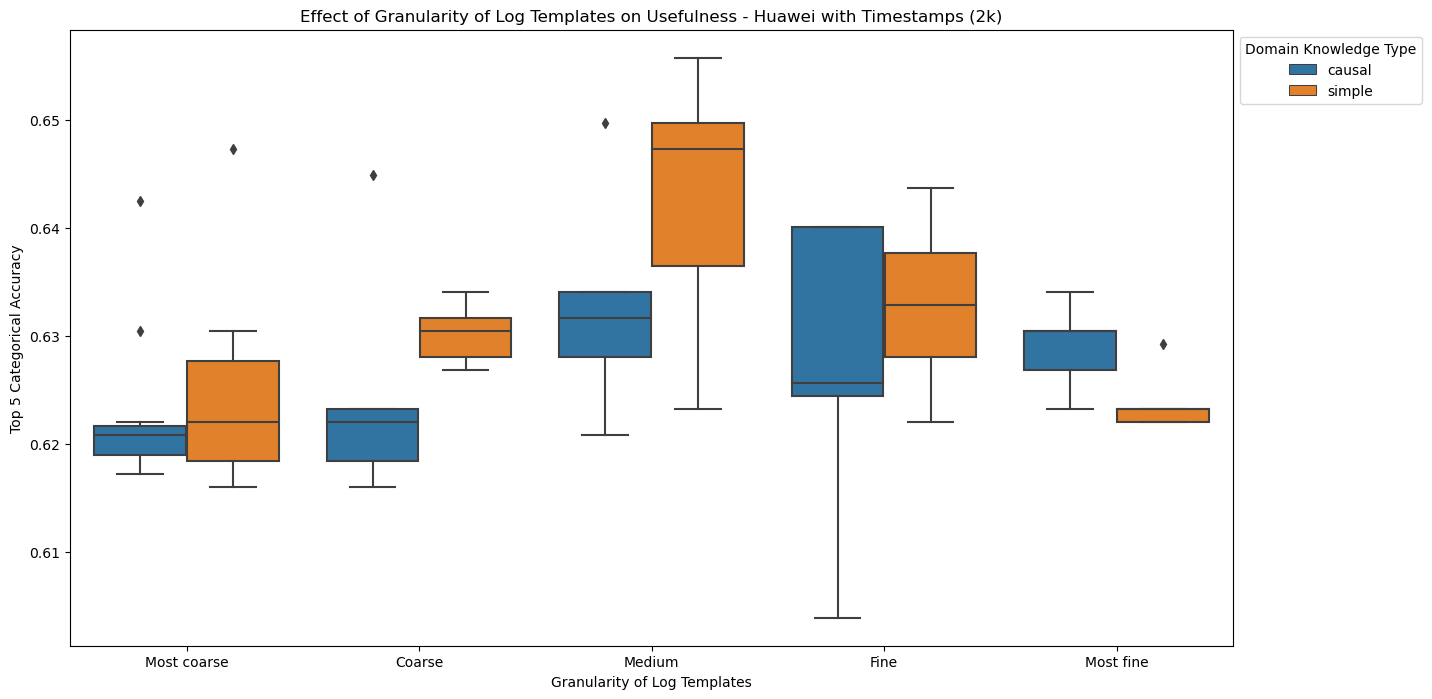

In [14]:
plt.figure(figsize=(15,8))
g = sns.boxplot(data=huawei_plot_ts_df,
                x='Granularity',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=config_order,
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Granularity of Log Templates')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Granularity of Log Templates on Usefulness - Huawei with Timestamps (2k)')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

#### Without timestamps

In [15]:
huawei_plot_without_ts_df = huawei_without_ts_df.copy()
huawei_plot_without_ts_df['algorithm_type'] = huawei_plot_without_ts_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
huawei_plot_without_ts_df['Granularity'] = (
    huawei_plot_without_ts_df
    .apply(lambda x: config2name[(x['data_params_HuaweiPreprocessorConfigfine_drain_log_depth'], x['data_params_HuaweiPreprocessorConfigfine_drain_log_st'])],
           axis=1))

In [16]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']

<AxesSubplot:title={'center':'Effect of Granularity of Log Templates on Usefulness - Huawei without Timestamps (2k)'}, xlabel='Granularity of Log Templates', ylabel='Top 5 Categorical Accuracy'>

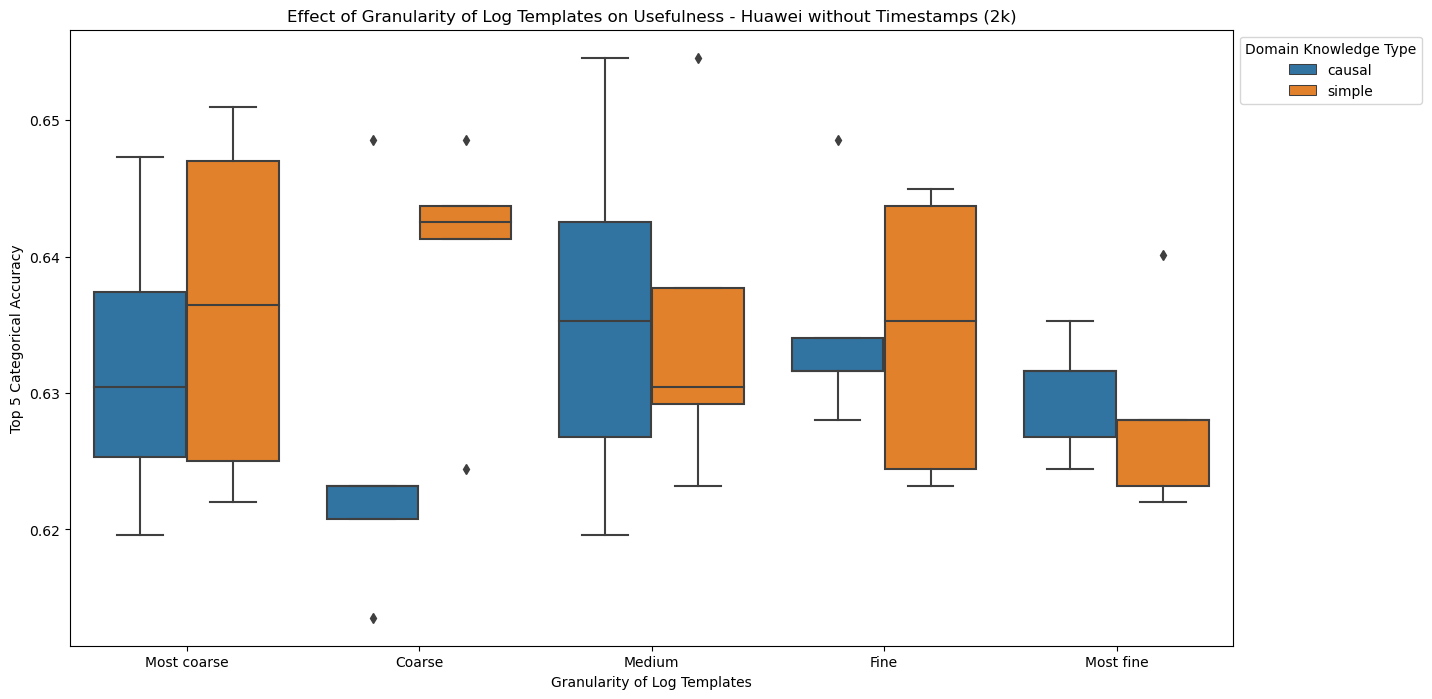

In [17]:
plt.figure(figsize=(15,8))
g = sns.boxplot(data=huawei_plot_without_ts_df,
                x='Granularity',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=config_order,
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Granularity of Log Templates')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Granularity of Log Templates on Usefulness - Huawei without Timestamps (2k)')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

### HDFS

In [18]:
hdfs_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'hdfs_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_HDFSPreprocessorConfigaggregated_log_file'] == 'data/final/2k/hdfs/HDFS_2k.csv')
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_HDFSPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("").isin(depth_values))
    & (mlflow_helper.run_df["data_params_HDFSPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(st_values))
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
hdfs_df = mlflow_helper.load_best_metrics_for_ids(set(hdfs_df["info_run_id"]))
hdfs_df = classify_sp_df(hdfs_df, name2config, dataset='HDFS')

Querying metrics for runs: 100%|██████████| 50/50 [00:03<00:00, 14.42it/s]


In [19]:
count_attributes(hdfs_df)

data_tags_model_type
causal_Fast-IAMB-jt_10_0.75    5
causal_Fast-IAMB-jt_11_0.8     5
causal_Fast-IAMB-jt_4_0.4      5
causal_Fast-IAMB-jt_6_0.6      5
causal_Fast-IAMB-jt_8_0.7      5
simple_10_0.75                 5
simple_11_0.8                  5
simple_4_0.4                   5
simple_6_0.6                   5
simple_8_0.7                   5
Name: data_tags_model_type, dtype: int64

In [20]:
hdfs_plot_df = hdfs_df.copy()
hdfs_plot_df['algorithm_type'] = hdfs_plot_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
hdfs_plot_df['Granularity'] = (
    hdfs_plot_df
    .apply(lambda x: config2name[(x['data_params_HDFSPreprocessorConfigfine_drain_log_depth'], x['data_params_HDFSPreprocessorConfigfine_drain_log_st'])],
           axis=1))

In [21]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']

<AxesSubplot:title={'center':'Effect of Granularity of Log Templates on Usefulness - HDFS (2k)'}, xlabel='Granularity of Log Templates', ylabel='Top 5 Categorical Accuracy'>

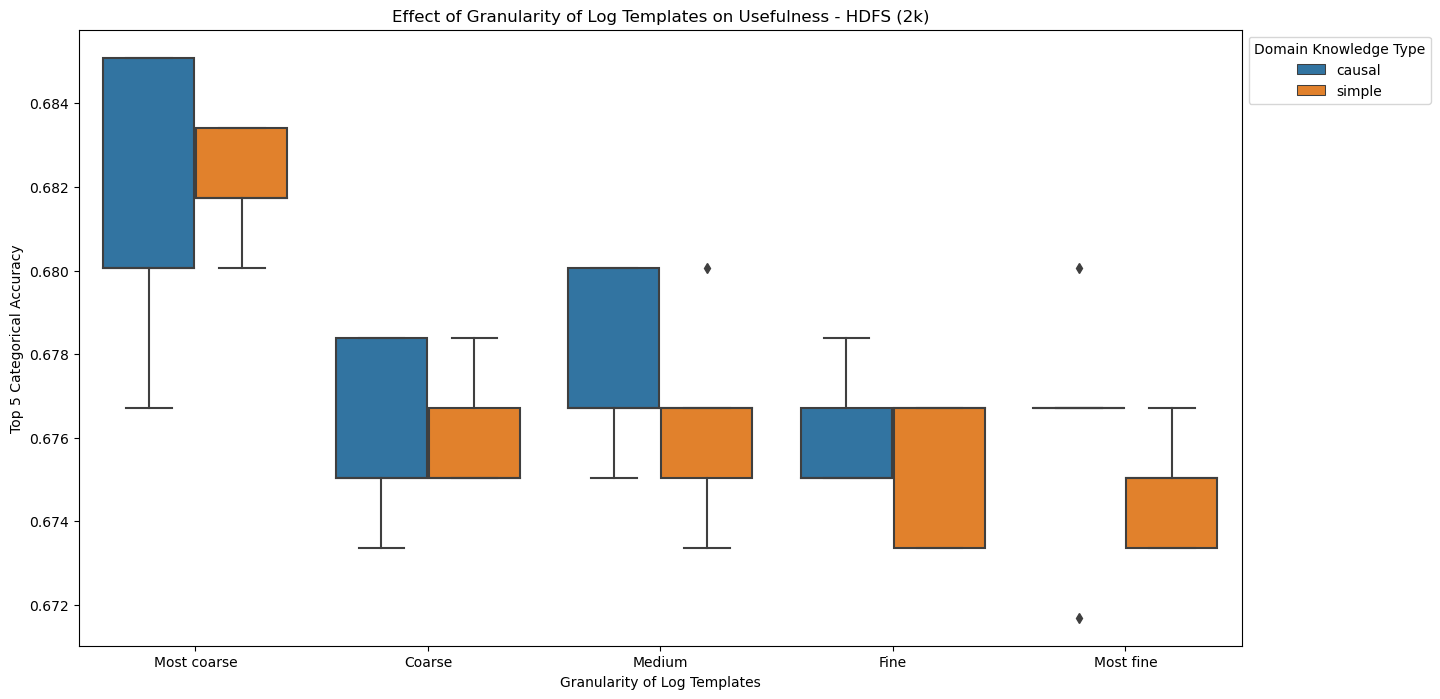

In [22]:
plt.figure(figsize=(15,8))
g = sns.boxplot(data=hdfs_plot_df,
                x='Granularity',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=config_order,
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Granularity of Log Templates')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Granularity of Log Templates on Usefulness - HDFS (2k)')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

## 5k

### Huawei

In [23]:
huawei_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'huawei_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/final/5k/huawei/Huawei_5k.csv')
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("").isin(depth_values))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(st_values))
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_df = classify_sp_df(huawei_df, name2config, dataset='Huawei')
huawei_with_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False']
huawei_without_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True']

Querying metrics for runs: 100%|██████████| 100/100 [00:06<00:00, 15.54it/s]


In [24]:
count_attributes(huawei_with_ts_df)

data_tags_model_type
causal_Fast-IAMB-jt_10_0.75    5
causal_Fast-IAMB-jt_11_0.8     5
causal_Fast-IAMB-jt_4_0.4      5
causal_Fast-IAMB-jt_6_0.6      5
causal_Fast-IAMB-jt_8_0.7      5
simple_10_0.75                 5
simple_11_0.8                  5
simple_4_0.4                   5
simple_6_0.6                   5
simple_8_0.7                   5
Name: data_tags_model_type, dtype: int64

In [25]:
count_attributes(huawei_without_ts_df)

data_tags_model_type
causal_Fast-IAMB-jt_10_0.75    5
causal_Fast-IAMB-jt_11_0.8     5
causal_Fast-IAMB-jt_4_0.4      5
causal_Fast-IAMB-jt_6_0.6      5
causal_Fast-IAMB-jt_8_0.7      5
simple_10_0.75                 5
simple_11_0.8                  5
simple_4_0.4                   5
simple_6_0.6                   5
simple_8_0.7                   5
Name: data_tags_model_type, dtype: int64

#### With timestamps

In [26]:
huawei_plot_ts_df = huawei_with_ts_df.copy()
huawei_plot_ts_df['algorithm_type'] = huawei_plot_ts_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
huawei_plot_ts_df['Granularity'] = (
    huawei_plot_ts_df
    .apply(lambda x: config2name[(x['data_params_HuaweiPreprocessorConfigfine_drain_log_depth'], x['data_params_HuaweiPreprocessorConfigfine_drain_log_st'])],
           axis=1))

In [27]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']

<AxesSubplot:title={'center':'Effect of Granularity of Log Templates on Usefulness - Huawei with Timestamps (5k)'}, xlabel='Granularity of Log Templates', ylabel='Top 5 Categorical Accuracy'>

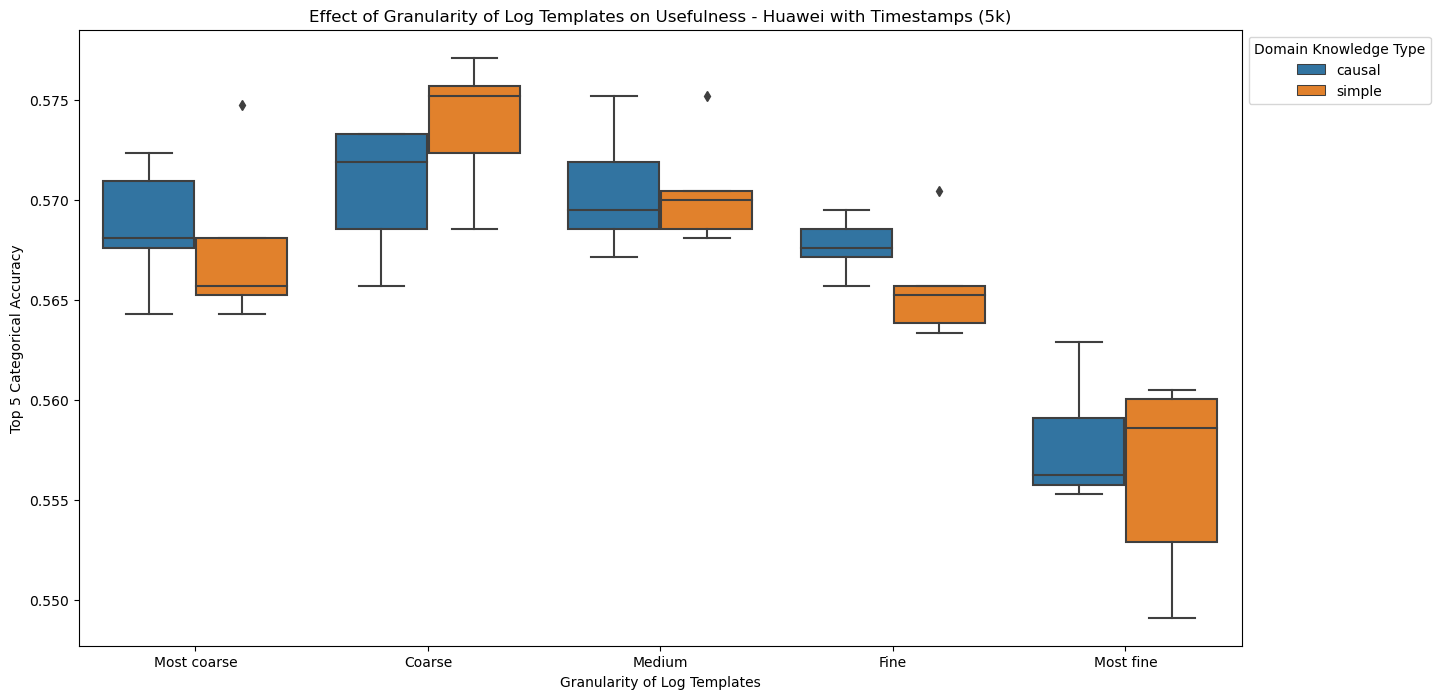

In [28]:
plt.figure(figsize=(15,8))
g = sns.boxplot(data=huawei_plot_ts_df,
                x='Granularity',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=config_order,
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Granularity of Log Templates')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Granularity of Log Templates on Usefulness - Huawei with Timestamps (5k)')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

#### Without timestamps

In [29]:
huawei_plot_without_ts_df = huawei_without_ts_df.copy()
huawei_plot_without_ts_df['algorithm_type'] = huawei_plot_without_ts_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
huawei_plot_without_ts_df['Granularity'] = (
    huawei_plot_without_ts_df
    .apply(lambda x: config2name[(x['data_params_HuaweiPreprocessorConfigfine_drain_log_depth'], x['data_params_HuaweiPreprocessorConfigfine_drain_log_st'])],
           axis=1))

In [30]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']

<AxesSubplot:title={'center':'Effect of Granularity of Log Templates on Usefulness - Huawei without Timestamps (5k)'}, xlabel='Granularity of Log Templates', ylabel='Top 5 Categorical Accuracy'>

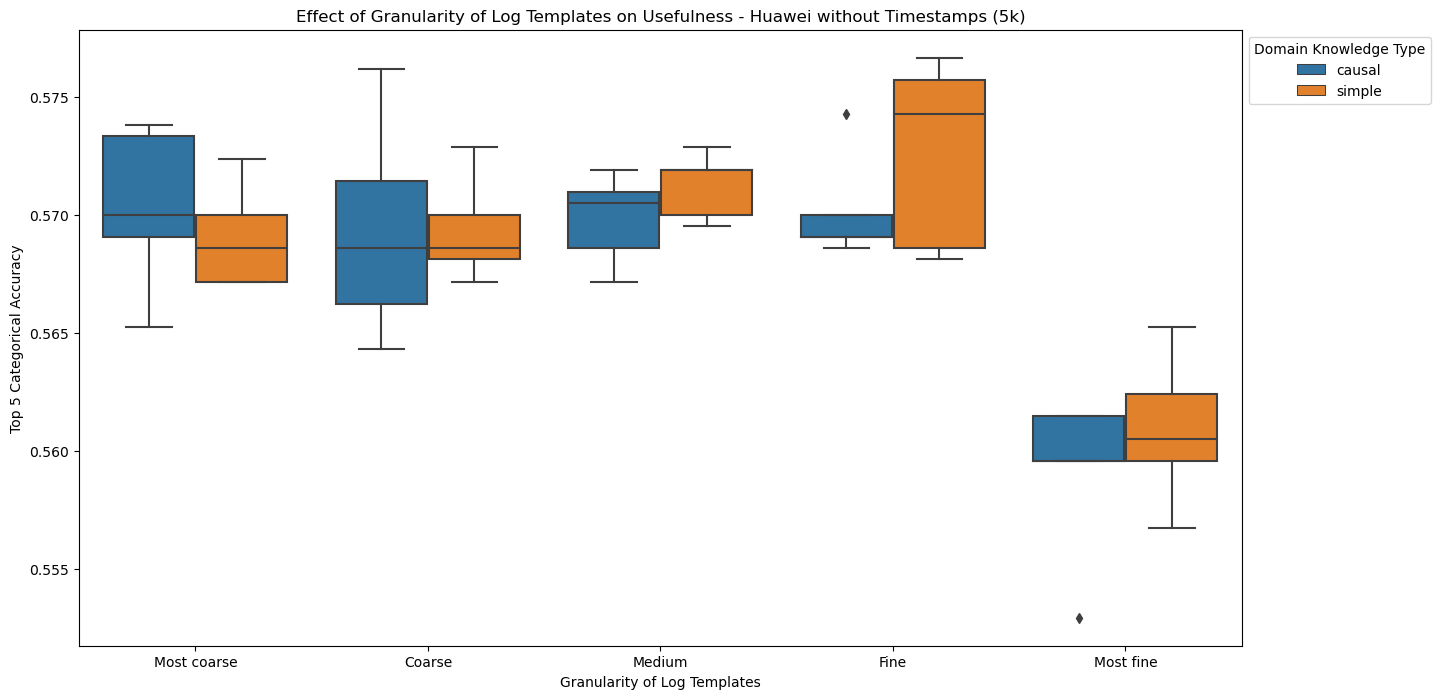

In [31]:
plt.figure(figsize=(15,8))
g = sns.boxplot(data=huawei_plot_without_ts_df,
                x='Granularity',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=config_order,
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Granularity of Log Templates')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Granularity of Log Templates on Usefulness - Huawei without Timestamps (5k)')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

### HDFS

In [32]:
hdfs_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'hdfs_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_HDFSPreprocessorConfigaggregated_log_file'] == 'data/final/5k/hdfs/HDFS_5k.csv')
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_HDFSPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("").isin(depth_values))
    & (mlflow_helper.run_df["data_params_HDFSPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(st_values))
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
hdfs_df = mlflow_helper.load_best_metrics_for_ids(set(hdfs_df["info_run_id"]))
hdfs_df = classify_sp_df(hdfs_df, name2config, dataset='HDFS')

Querying metrics for runs: 100%|██████████| 50/50 [00:03<00:00, 16.09it/s]


In [33]:
count_attributes(hdfs_df)

data_tags_model_type
causal_Fast-IAMB-jt_10_0.75    5
causal_Fast-IAMB-jt_11_0.8     5
causal_Fast-IAMB-jt_4_0.4      5
causal_Fast-IAMB-jt_6_0.6      5
causal_Fast-IAMB-jt_8_0.7      5
simple_10_0.75                 5
simple_11_0.8                  5
simple_4_0.4                   5
simple_6_0.6                   5
simple_8_0.7                   5
Name: data_tags_model_type, dtype: int64

In [34]:
hdfs_plot_df = hdfs_df.copy()
hdfs_plot_df['algorithm_type'] = hdfs_plot_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
hdfs_plot_df['Granularity'] = (
    hdfs_plot_df
    .apply(lambda x: config2name[(x['data_params_HDFSPreprocessorConfigfine_drain_log_depth'], x['data_params_HDFSPreprocessorConfigfine_drain_log_st'])],
           axis=1))

In [35]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']

<AxesSubplot:title={'center':'Effect of Granularity of Log Templates on Usefulness - HDFS (5k)'}, xlabel='Granularity of Log Templates', ylabel='Top 5 Categorical Accuracy'>

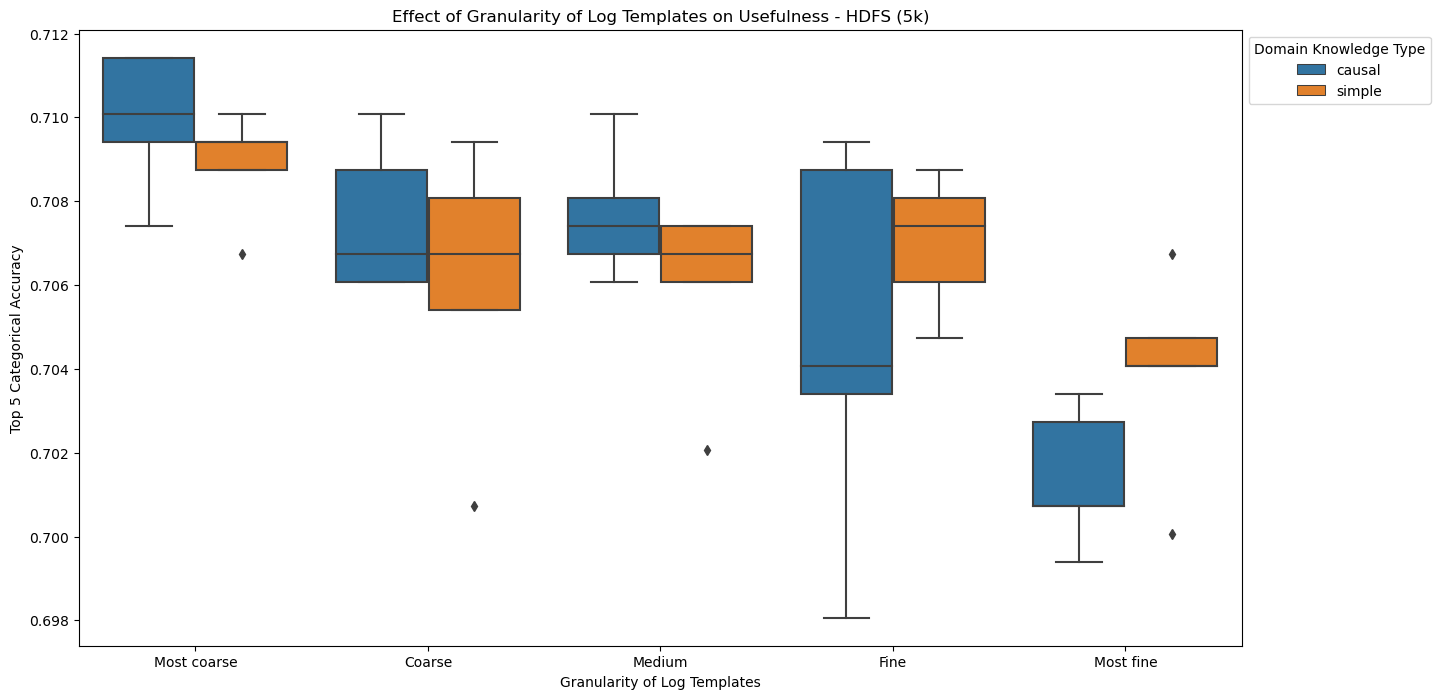

In [36]:
plt.figure(figsize=(15,8))
g = sns.boxplot(data=hdfs_plot_df,
                x='Granularity',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=config_order,
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Granularity of Log Templates')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Granularity of Log Templates on Usefulness - HDFS (5k)')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

## 10k

### Huawei

In [37]:
huawei_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'huawei_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/final/10k/huawei/Huawei_10k.csv')
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("").isin(depth_values))
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(st_values))
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_df = classify_sp_df(huawei_df, name2config, dataset='Huawei')
huawei_with_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False']
huawei_without_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True']

Querying metrics for runs: 100%|██████████| 99/99 [00:06<00:00, 15.91it/s]


In [38]:
count_attributes(huawei_with_ts_df)

data_tags_model_type
causal_Fast-IAMB-jt_10_0.75    5
causal_Fast-IAMB-jt_11_0.8     5
causal_Fast-IAMB-jt_4_0.4      5
causal_Fast-IAMB-jt_6_0.6      5
causal_Fast-IAMB-jt_8_0.7      5
simple_10_0.75                 5
simple_11_0.8                  5
simple_4_0.4                   5
simple_6_0.6                   5
simple_8_0.7                   5
Name: data_tags_model_type, dtype: int64

In [39]:
count_attributes(huawei_without_ts_df)

data_tags_model_type
causal_Fast-IAMB-jt_10_0.75    5
causal_Fast-IAMB-jt_11_0.8     5
causal_Fast-IAMB-jt_4_0.4      5
causal_Fast-IAMB-jt_6_0.6      5
causal_Fast-IAMB-jt_8_0.7      5
simple_10_0.75                 5
simple_4_0.4                   5
simple_6_0.6                   5
simple_8_0.7                   5
simple_11_0.8                  4
Name: data_tags_model_type, dtype: int64

#### With timestamps

In [40]:
huawei_plot_ts_df = huawei_with_ts_df.copy()
huawei_plot_ts_df['algorithm_type'] = huawei_plot_ts_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
huawei_plot_ts_df['Granularity'] = (
    huawei_plot_ts_df
    .apply(lambda x: config2name[(x['data_params_HuaweiPreprocessorConfigfine_drain_log_depth'], x['data_params_HuaweiPreprocessorConfigfine_drain_log_st'])],
           axis=1))

In [41]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']

<AxesSubplot:title={'center':'Effect of Granularity of Log Templates on Usefulness - Huawei with Timestamps (10k)'}, xlabel='Granularity of Log Templates', ylabel='Top 5 Categorical Accuracy'>

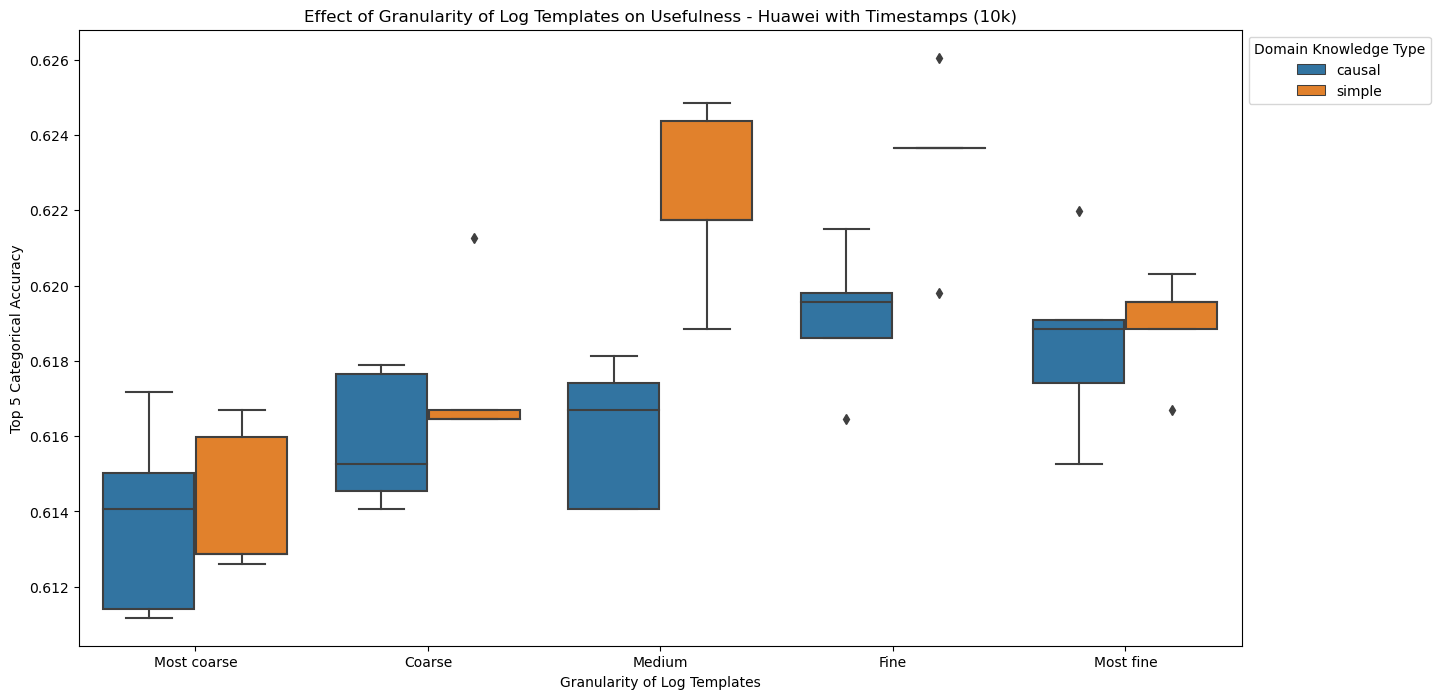

In [42]:
plt.figure(figsize=(15,8))
g = sns.boxplot(data=huawei_plot_ts_df,
                x='Granularity',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=config_order,
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Granularity of Log Templates')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Granularity of Log Templates on Usefulness - Huawei with Timestamps (10k)')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

#### Without timestamps

In [43]:
huawei_plot_without_ts_df = huawei_without_ts_df.copy()
huawei_plot_without_ts_df['algorithm_type'] = huawei_plot_without_ts_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
huawei_plot_without_ts_df['Granularity'] = (
    huawei_plot_without_ts_df
    .apply(lambda x: config2name[(x['data_params_HuaweiPreprocessorConfigfine_drain_log_depth'], x['data_params_HuaweiPreprocessorConfigfine_drain_log_st'])],
           axis=1))

In [44]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']

<AxesSubplot:title={'center':'Effect of Granularity of Log Templates on Usefulness - Huawei without Timestamps (10k)'}, xlabel='Granularity of Log Templates', ylabel='Top 5 Categorical Accuracy'>

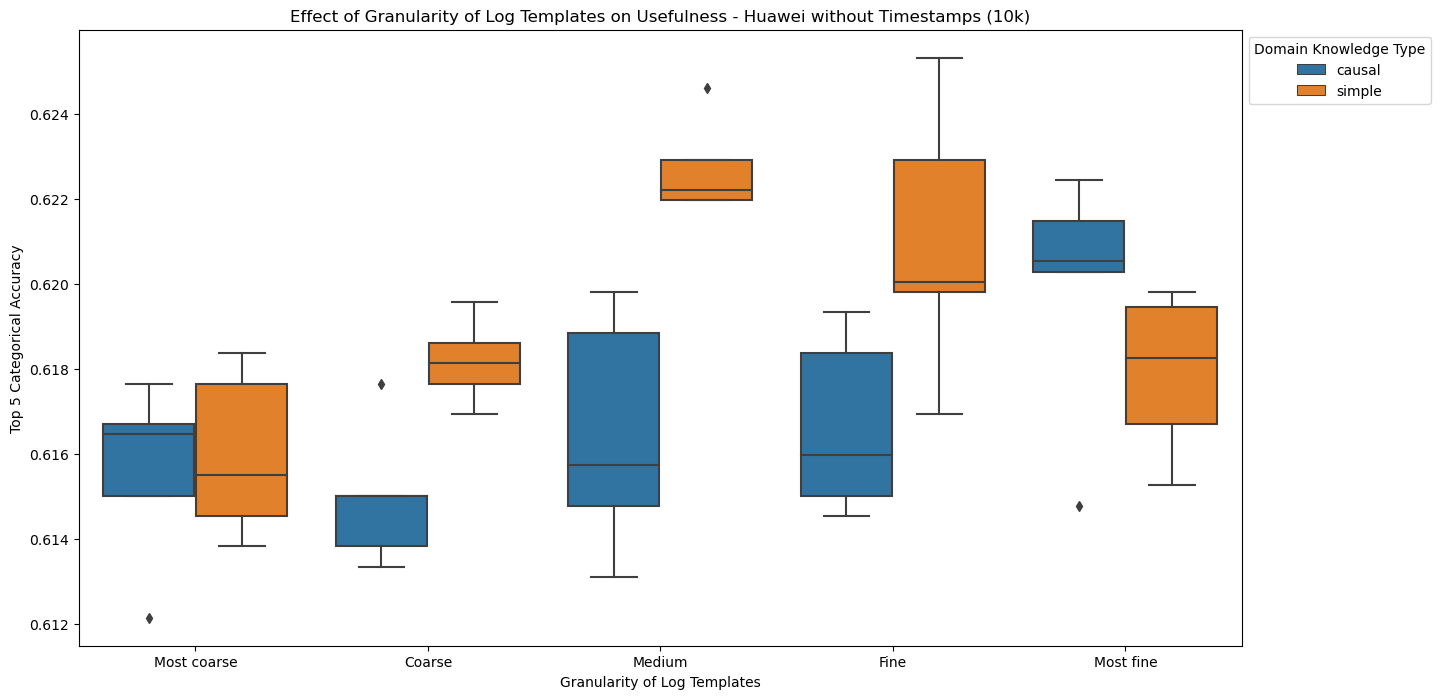

In [45]:
plt.figure(figsize=(15,8))
g = sns.boxplot(data=huawei_plot_without_ts_df,
                x='Granularity',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=config_order,
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Granularity of Log Templates')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Granularity of Log Templates on Usefulness - Huawei without Timestamps (10k)')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

### HDFS

In [46]:
hdfs_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'hdfs_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_HDFSPreprocessorConfigaggregated_log_file'] == 'data/final/10k/hdfs/HDFS_10k.csv')
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_HDFSPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("").isin(depth_values))
    & (mlflow_helper.run_df["data_params_HDFSPreprocessorConfigfine_drain_log_st"].astype(str).fillna("").isin(st_values))
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
hdfs_df = mlflow_helper.load_best_metrics_for_ids(set(hdfs_df["info_run_id"]))
hdfs_df = classify_sp_df(hdfs_df, name2config, dataset='HDFS')

Querying metrics for runs: 100%|██████████| 50/50 [00:03<00:00, 16.01it/s]


In [47]:
count_attributes(hdfs_df)

data_tags_model_type
causal_Fast-IAMB-jt_10_0.75    5
causal_Fast-IAMB-jt_11_0.8     5
causal_Fast-IAMB-jt_4_0.4      5
causal_Fast-IAMB-jt_6_0.6      5
causal_Fast-IAMB-jt_8_0.7      5
simple_10_0.75                 5
simple_11_0.8                  5
simple_4_0.4                   5
simple_6_0.6                   5
simple_8_0.7                   5
Name: data_tags_model_type, dtype: int64

In [48]:
hdfs_plot_df = hdfs_df.copy()
hdfs_plot_df['algorithm_type'] = hdfs_plot_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
hdfs_plot_df['Granularity'] = (
    hdfs_plot_df
    .apply(lambda x: config2name[(x['data_params_HDFSPreprocessorConfigfine_drain_log_depth'], x['data_params_HDFSPreprocessorConfigfine_drain_log_st'])],
           axis=1))

In [49]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']

<AxesSubplot:title={'center':'Effect of Granularity of Log Templates on Usefulness - HDFS (10k)'}, xlabel='Granularity of Log Templates', ylabel='Top 5 Categorical Accuracy'>

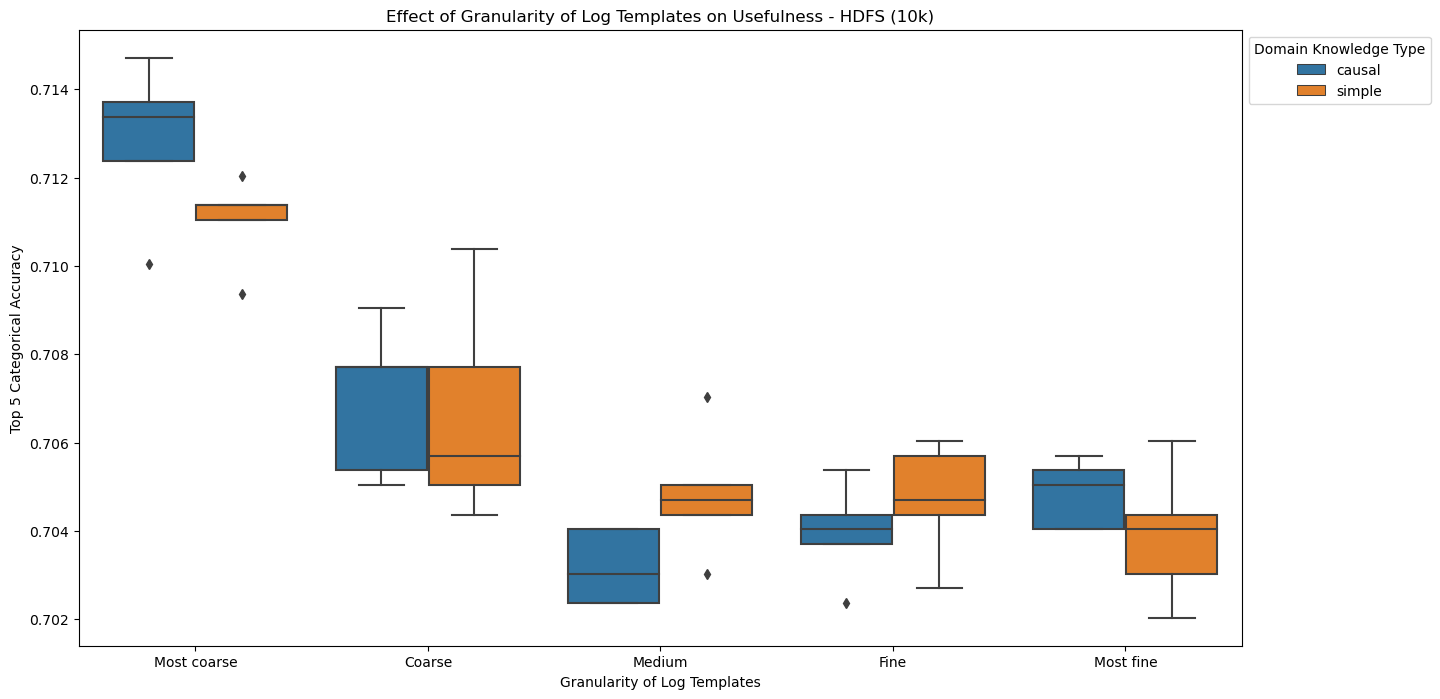

In [50]:
plt.figure(figsize=(15,8))
g = sns.boxplot(data=hdfs_plot_df,
                x='Granularity',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=config_order,
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Granularity of Log Templates')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Granularity of Log Templates on Usefulness - HDFS (10k)')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

# Dataset Size Effect

In [51]:
def dataset_size_classifier(data_path):
    if '2k' in data_path:
        return '2000'
    elif '5k' in data_path:
        return '5000'
    elif '10k' in data_path:
        return '10000'

## Huawei

In [52]:
mlflow_helper_full = MlflowHelper(
    pkl_file=Path('/home/i40/almasrirz/Domain-Guided-Monitoring/data/domainml.pkl'),
    local_mlflow_dir_prefix='/home/i40/almasrirz/Domain-Guided-Monitoring/mlruns/', 
    experiment_id="831333387297563441",
    tracking_uri="http://localhost:5200")
full_huawei_runs = mlflow_helper_full.run_df[
    (mlflow_helper_full.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper_full.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper_full.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'] == 'data/logs_aggregated_concurrent_original.csv')
    & (mlflow_helper_full.run_df["info_status"] == "FINISHED")
    & (mlflow_helper_full.run_df['data_params_ExperimentConfigmax_data_size'] == '-1')
    & (mlflow_helper_full.run_df['data_params_HuaweiPreprocessorConfigcausal_algorithm_alpha'].fillna("").isin(["", '0.05']))
    & (mlflow_helper_full.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].fillna("") == "0.75")
    & (mlflow_helper_full.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == "10")
    & (mlflow_helper_full.run_df['data_params_ExperimentConfigonly_generate_knowledge'].astype(str).fillna("").isin(["", "False"]))
    & (
        (
            (mlflow_helper_full.run_df['data_tags_model_type'] == 'causal_Fast-IAMB-jt') &
            (mlflow_helper_full.run_df['data_params_TimeSeriesTransformerConfigbin_size'] == '00:00:05') &
            (mlflow_helper_full.run_df['data_params_TimeSeriesTransformerConfigbin_overlap'] == '00:00:01')
        ) | (mlflow_helper_full.run_df['data_tags_model_type'] == 'simple')
    )   
]
full_huawei_runs = mlflow_helper_full.load_best_metrics_for_ids(set(full_huawei_runs["info_run_id"]))
full_huawei_runs['dataset_size'] = 'Full (169230)'

Initialized with 5746 MLFlow runs from pkl


Querying metrics for runs: 100%|██████████| 75/75 [00:04<00:00, 15.87it/s]


In [53]:
data_paths = ['data/final/2k/huawei/Huawei_2k.csv', 'data/final/5k/huawei/Huawei_5k.csv', 'data/final/10k/huawei/Huawei_10k.csv']
default_drain_config = name2config['Fine']
huawei_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'huawei_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'].isin(data_paths))
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == default_drain_config[0])
    & (mlflow_helper.run_df["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(str).fillna("") == default_drain_config[1])
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
huawei_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_df['dataset_size'] = huawei_df['data_params_HuaweiPreprocessorConfigaggregated_log_file'].apply(lambda x: dataset_size_classifier(x))
huawei_df = pd.concat([huawei_df, full_huawei_runs], ignore_index=True).reset_index(drop=True)
huawei_df['algorithm_type'] = huawei_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])
huawei_with_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'False']
huawei_without_ts_df = huawei_df[huawei_df['data_params_HuaweiPreprocessorConfigremove_dates_from_payload'] == 'True']

Querying metrics for runs: 100%|██████████| 60/60 [00:03<00:00, 15.56it/s]


In [54]:
huawei_with_ts_df.groupby(['dataset_size', 'algorithm_type']).size()

dataset_size   algorithm_type
10000          causal             5
               simple             5
2000           causal             5
               simple             5
5000           causal             5
               simple             5
Full (169230)  causal            15
               simple            20
dtype: int64

In [55]:
huawei_without_ts_df.groupby(['dataset_size', 'algorithm_type']).size()

dataset_size   algorithm_type
10000          causal             5
               simple             5
2000           causal             5
               simple             5
5000           causal             5
               simple             5
Full (169230)  causal            20
               simple            20
dtype: int64

### With timestamps

<AxesSubplot:title={'center':'Effect of Dataset Size on Usefulness - Huawei with timestamps'}, xlabel='Dataset Size', ylabel='Top 5 Categorical Accuracy'>

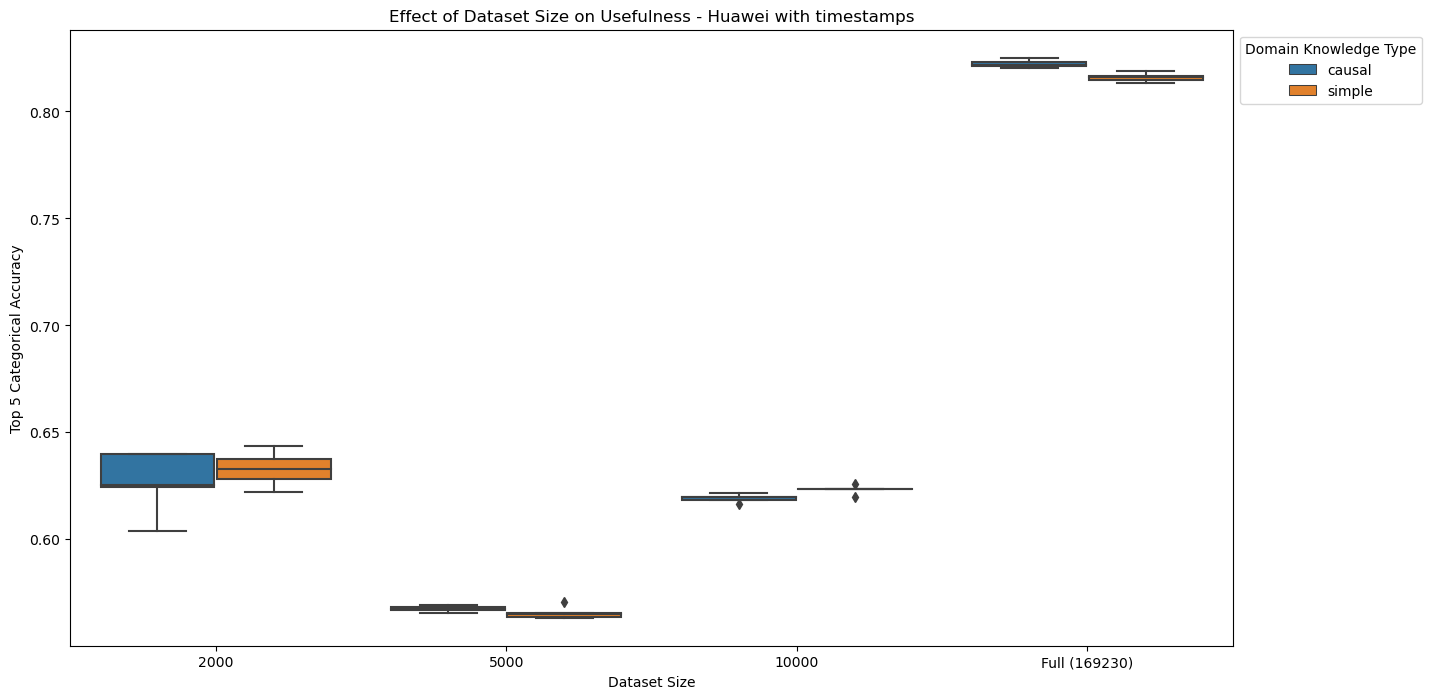

In [56]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']
plt.figure(figsize=(15,8))
g = sns.boxplot(data=huawei_with_ts_df,
                x='dataset_size',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=['2000', '5000', '10000', 'Full (169230)'],
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Dataset Size')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Dataset Size on Usefulness - Huawei with timestamps')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

### Without Timestamps

<AxesSubplot:title={'center':'Effect of Dataset Size on Usefulness - Huawei without timestamps'}, xlabel='Dataset Size', ylabel='Top 5 Categorical Accuracy'>

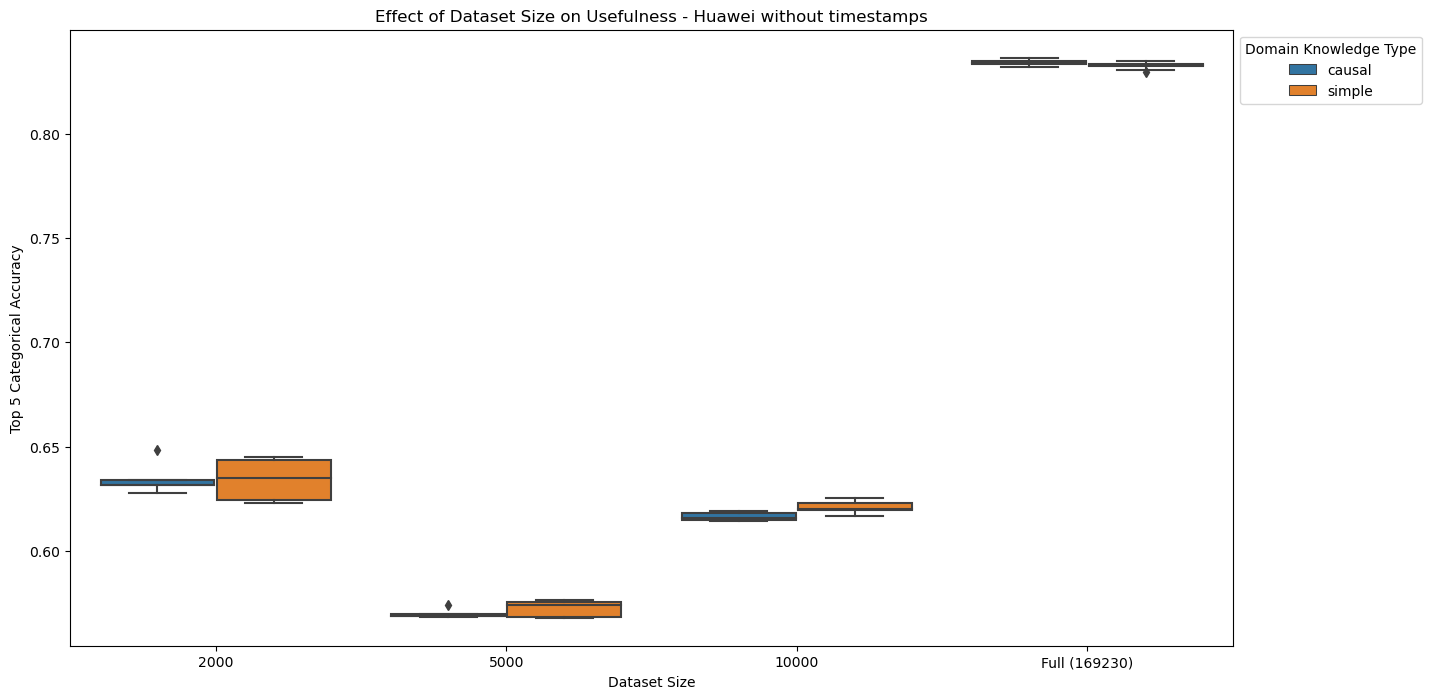

In [57]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']
plt.figure(figsize=(15,8))
g = sns.boxplot(data=huawei_without_ts_df,
                x='dataset_size',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=['2000', '5000', '10000', 'Full (169230)'],
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Dataset Size')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Dataset Size on Usefulness - Huawei without timestamps')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g

## HDFS

In [58]:
data_paths = ['data/final/2k/hdfs/HDFS_2k.csv', 'data/final/5k/hdfs/HDFS_5k.csv', 'data/final/10k/hdfs/HDFS_10k.csv']
default_drain_config = name2config['Fine']
hdfs_df = mlflow_helper.run_df[
    (mlflow_helper.run_df['data_tags_sequence_type'] == 'hdfs_logs')
    & (mlflow_helper.run_df['data_tags_model_type'].isin(['simple', 'causal_Fast-IAMB-jt']))
    & (mlflow_helper.run_df['data_params_HDFSPreprocessorConfigaggregated_log_file'].isin(data_paths))
    & (mlflow_helper.run_df["info_status"] == "FINISHED")
    & (mlflow_helper.run_df["data_params_HDFSPreprocessorConfigfine_drain_log_depth"].astype(str).fillna("") == default_drain_config[0])
    & (mlflow_helper.run_df["data_params_HDFSPreprocessorConfigfine_drain_log_st"].astype(str).fillna("") == default_drain_config[1])
    & (mlflow_helper.run_df['data_params_ExperimentConfigonly_generate_knowledge'] == 'False')
]
hdfs_df = mlflow_helper.load_best_metrics_for_ids(set(hdfs_df["info_run_id"]))
hdfs_df['dataset_size'] = hdfs_df['data_params_HDFSPreprocessorConfigaggregated_log_file'].apply(lambda x: dataset_size_classifier(x))
hdfs_df['algorithm_type'] = hdfs_df['data_tags_model_type'].apply(lambda x: x.split('_')[0])

Querying metrics for runs: 100%|██████████| 30/30 [00:01<00:00, 16.26it/s]


In [59]:
hdfs_df.groupby(['dataset_size', 'algorithm_type']).size()

dataset_size  algorithm_type
10000         causal            5
              simple            5
2000          causal            5
              simple            5
5000          causal            5
              simple            5
dtype: int64

<AxesSubplot:title={'center':'Effect of Dataset Size on Usefulness - HDFS'}, xlabel='Dataset Size', ylabel='Top 5 Categorical Accuracy'>

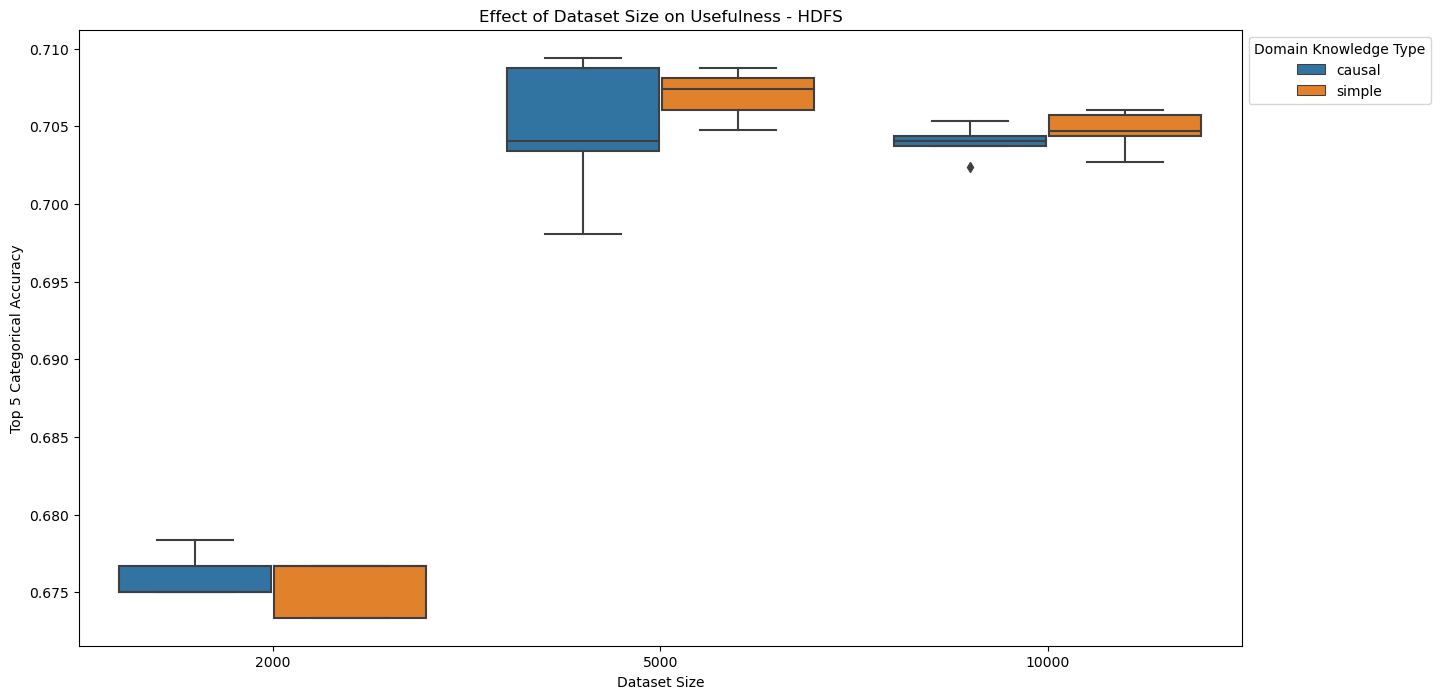

In [60]:
colors = {'causal': 'C0', 'simple': 'C1'}
hue_order = ['causal', 'simple']
plt.figure(figsize=(15,8))
g = sns.boxplot(data=hdfs_df,
                x='dataset_size',
                y='val_top_5_categorical_accuracy_history_best',
                hue='algorithm_type',
                order=['2000', '5000', '10000'],
                palette=colors,
                hue_order=hue_order,)
g.set_xlabel('Dataset Size')
g.set_ylabel('Top 5 Categorical Accuracy')
g.legend(title='Domain Knowledge Type')
g.set_title('Effect of Dataset Size on Usefulness - HDFS')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
g